 * ### AI-based Resource Provisioning of IoE Services in 6G: A Deep Reinforcement Learning Approach
 * ### Date: 13-03-2021
 * ### Author: Hani Sami (hani.sami@mail.concordia.ca)
 * ### IEEE TNSM 2021

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date
from collections import OrderedDict
import random
import math
import sys
import pickle
import seaborn as sns
import itertools
import copy
from tqdm.notebook import tqdm

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses

# Data Preparation

## Input

In [3]:
# Each host has the following information:
# available cpu, memory, disk, time available to serve
hosts = [
    [1.0, 1.0, 1.0, 10],
    [0.8, 0.5, 0.5, 20],
    [0.9, 0.9, 0.9, 30]
]

In [4]:
# Each container has the following information
# Required cpu, memory, disk, and priority level

container = [[0.5, 0.2, 0.2, 0],
            [0.3, 0.2, 0.2, 1],
            [0.25,0.25, 0.25, 0]]

## Action Space

In [5]:
def getActionSpace(limit):
    actions = []
    for i in range(limit):
        actions.append((i+1) * -1)
    actions.append(0)
    for i in range(limit):
        actions.append(i+1)
    for i in range(9):
        actions.append(round((i+1)*0.1, 2))
    for i in range(9):
        actions.append(round((i+1)*-0.1, 2))
    return actions
    

In [6]:
actions = getActionSpace(1)

## Read demands and available resource data from Google Cluster Usage Trace dataset:
https://drive.google.com/file/d/10r6cnJ5cJ89fPWCgj7j4LtLBqYN9RiI9/view

### A sample from this dataset is used below

In [7]:
responseList = [[0.2, 0.3, 0.1],
               [0.4, 0.2, 0.2],
               [0.3, 0.3,0.3],
               [0.3, 0.3, 0.4],
               [0.1, 0.1, 0.2]]

In [8]:
resourceLoadHosts = [[0.21, 0.21,0.32],
                    [0.19, 0.15, 0.21],
                    [0.12, 0.25, 0.3],
                    [0.32, 0.27, 0.12],
                    [0.26, 0.36, 0.1]]

# Common Functions

## Retrieve the next state following the current state and action taken

In [9]:
def getNextState(timestep, responsesList, resourceLoadHosts, state, action, hosts, container):
    placement = copy.deepcopy(state[1])
    newLoad = state[2]
    p = state[3]
    q = state[4]
    newResponse = state[0]
    placement[state[4]][state[3]] = round(placement[state[4]][state[3]] + action, 2)
    newResponseFinal = responsesList[timestep%5]
    newLoadFinal = resourceLoadHosts[timestep%5]
    if q + 1 == len(hosts):
        q = 0   
        if p + 1 == len(container):
            p = 0
            newResponse = responsesList[timestep%5]
            newLoad = resourceLoadHosts[timestep%5]
        else:
            p = p + 1
    else:
        q = q + 1
    nextState = [newResponse, placement, newLoad, p, q]
    
    return nextState

## Check if the selected action is feasible

In [10]:
def isActionFeasible(state, previousState, action, container, hosts):
    possible = True
    if (previousState[1][previousState[4]][previousState[3]] + action) < 0:
        possible = False
    totalPlac = 0.0
    for plan in previousState[1][previousState[4]]:
        totalPlac = totalPlac + plan
    if totalPlac + action < 0:
        possible = False
    return possible

## Retrieve the list of possible actions for the current state

In [11]:
def getPossibleActionsFromState(state, container, hosts, actions):
    #check the +1 and if it is enough for the resources
    possibleActions = []
    for action in actions:
        possible = True
        if (state[1][state[4]][state[3]] + action) < 0:
            possible = False 
        totalPlac = 0.0
        for plan in state[1][state[4]]:
            totalPlac = totalPlac + plan
        if totalPlac + action < 0 or totalPlac + action > 2 * (1 - state[2][state[4]]):
            possible = False
        if possible:
            possibleActions.append(action)
    return possibleActions

# Cost Function 

In [12]:
def resourceCost(state, previousState, action, container, hosts):
    summ = 0
    for i in range(len(state[1])):
        hostUsage = 0
        usage = 0
        for j in range(len(container)):
            hostUsage = hostUsage + (state[1][i][j])
            if hostUsage > state[0][j]:
                usage = usage + (hostUsage - state[0][j])
        if hostUsage < 0 or hostUsage > 1 - state[2][i]:
            summ = summ + 10
            continue
        
        summ = summ + usage
    sumAv = 0.0
    for gg in state[2]:
        sumAv = sumAv + (1 - gg)
    return summ / sumAv

In [13]:
def refreshCost(state):
    sumPlacement = 0
    cost = 0
    
    for placement in state[1]:
        for plac in placement:
            if plac <= 0:
                continue
            else:
                sumPlacement = sumPlacement + (plac)
    return sumPlacement / len(state[1]) * len(state[1][0])

In [14]:
def responseCost(nextState, hosts, container):
    cost = 0
    for i in range(len(container)):
        sumPlacement = 0
        for j in range(len(nextState[1])):
            sumPlacement = sumPlacement + nextState[1][j][i]

        if sumPlacement >= nextState[0][i] or nextState[0][i] == 0 or sumPlacement < 0:
            continue
        maxI =  nextState[0][i]
        cost = cost + ((maxI - (sumPlacement)) / maxI)

    return cost

In [15]:
def distanceCost(state, Hosts):
    #get the max distance sum
    distances = 0
    maxSumDistance = 0
    for i in range(len(hosts)):
        sumPlac = 0
        for pac in range(len(state[1][i])):
            sumPlac = sumPlac + pac
        if(sumPlac <= 0):
            continue
        distances = distances + (sumPlac * (hosts[2][3] - hosts[i][3]))
        maxSumDistance = maxSumDistance + ((hosts[2][3]-hosts[0][3]) * sumPlac)
    if maxSumDistance == 0:
        return 0
    return float(distances) / (maxSumDistance)

In [16]:
def priorityCost(state, container):
    totalC = 0
    ser = 0
    sumPlac = 0
    for j in range(len(container)):
        if container[j][3] == 0:
            continue
        ser = j
        for i in range(len(state[1])):
            sumPlac = sumPlac + state[1][i][j]
    if sumPlac < state[0][ser]:
        return (state[0][ser] - sumPlac) / state[0][ser]
    return 0

In [17]:
def totalCost(state, previousState, action, hosts, containers, w1, w2, w3, w5):
    c1 = resourceCost(state, previousState, action, container, hosts) * w1
    c2 = responseCost(state, hosts, containers) * w2
    c3 = distanceCost(state, hosts) * w3
    c5 = priorityCost(state, containers) * w5
    return c1 + c2 + c3 + c5

# DQN

## Source and target networks initialization

In [18]:
replayBuffer = []

# The dimensions of the input for the source and target networks
dimensions = len(hosts) + (len(hosts)*len(container)) + 4

model = Sequential()
model.add(Dense(32, input_dim=dimensions, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(16, activation='relu',kernel_initializer='random_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(1, activation='linear', kernel_initializer='random_normal'))
#Initialize target action value function Qhat with weight theta- = theta
targetModel = Sequential()
targetModel.add(Dense(32, input_dim=dimensions, activation='relu'))
targetModel.add(Dense(16, activation='relu'))
targetModel.add(Dense(8, activation='relu'))
targetModel.add(Dense(1, activation='linear'))
#set target model weights to the model
modelWeights = []
for layer in model.layers: 
    modelWeights.append(layer.get_weights())
# counterWeights = 0
# for layer in model.layers:
#     layer.set_weights(weights[counterWeights])
#     counterWeights = counterWeights + 1
counterWeights = 0
for layer in targetModel.layers:
    layer.set_weights(modelWeights[counterWeights])
    counterWeights = counterWeights + 1
huberLoss = losses.Huber()
optimizerRMS = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss=huberLoss, optimizer=optimizerRMS)
targetModel.compile(loss=huberLoss, optimizer=optimizerRMS)

## Common functions used in the DQN implementation

In [19]:
def resourcesResult(pl, resources, container):
    resultsResources = []
    availableResources = []
    for res in resources:
        availableResources.append(1.0 - res)
    for res in range(len(availableResources)):
        cpuUsed = 0
        for pac in range(len(container)):
            cpuUsed = pl[res][pac]
        resultsResources.append(cpuUsed)
    return ([resultsResources, availableResources])

In [20]:
def sumPlacement(pl):
    sum = 0
    for n in pl:
        for pac in n:
            sum = sum + pac
    return sum

In [21]:
def getEmptyPlacement(hosts, container):
    p = []
    for i in range(len(hosts)):
        temp = []
        for j in range(len(container)):
            temp.append(0)
        p.append(temp)
    return p

In [22]:
def getNewRandomState(hosts, responses, resources, container):
    placement = getEmptyPlacement(hosts, container)
    respRand = random.randrange(5)
    response = responses[respRand]
    resouRand = random.randrange(5)
    resource = resources[resouRand]
    return (response, placement, resource, 0, 0)

In [23]:
def getNNInput(state, action):
    result = []
    result.append(state[0][0])
    result.append(state[0][1])
    for i in state[1]:
        for j in i:
            result.append(j)
    for i in state[2]:
        result.append(i)
    result.append(state[3])
    result.append(state[4])
    return result

In [24]:
def getRandomMiniBatchPrepareModelFit(replayBuffer, targetModel, discountFactor, actionBinary):
    #get 1000 samples
    randomTransitionsIndeces = random.sample(range(0, len(replayBuffer)), 60)
    trainingDataModel = []
    trainingDataLabelTargetModel = []
    for index in randomTransitionsIndeces:
        labelSample = 0.0
        trainSample = getNNInput(replayBuffer[index][0], replayBuffer[index][1])
        trainingDataModel.append(trainSample)
        #get max qvalue on target network
        if(replayBuffer[index][3][2] == 0):
              labelSample = replayBuffer[index][2]
        else:
            actionTakenIndex = 0
            minQValue = sys.maxsize
            for actionIndex in range(len(actionBinary)):
                nnInput = getNNInput(replayBuffer[index][3], actionBinary[actionIndex])
                #get qvalue as output of Neural Network
                actionQValueT = np.array([nnInput])
                actionQValue = targetModel.predict(actionQValueT)[0][0]
                if minQValue > actionQValue:
                    actionTakenIndex = actionIndex
                    minQValue = actionQValue
            labelSample = replayBuffer[index][2] + (discountFactor * minQValue)
        trainingDataLabelTargetModel.append(labelSample)
    output = (trainingDataModel, trainingDataLabelTargetModel)
    return output

## Variables initialization used in DQN of IScaler

In [25]:
episode = 0
k = 0
replayBuffer = []
discountFactor = 0.9
costsList = []
costsListC1 = []
costsListC2 = []
costsListC3 = []
resultsResourcesList1 = []
resultsResponsesList1 = []
p1=[]
counter12 = 0
p = 1
state = getNewRandomState(hosts, responseList, resourceLoadHosts, container)

In [26]:
state

([0.3, 0.3, 0.4], [[0, 0, 0], [0, 0, 0], [0, 0, 0]], [0.12, 0.25, 0.3], 0, 0)

## Main learning algorithm

In [27]:
for _ in tqdm(range(100)):# episode
    for _ in tqdm(range(300)):
        # Apply e-greedy policy
        k = k + 1
        minQValue = False
        e = 1000 / (1000 + counter12)
        randomValue = random.random()
        if randomValue <= (1 - e):
            minQValue = True
        minQValueSample = sys.maxsize
        actionTakenIndex = 0
        act = getPossibleActionsFromState(state, container, hosts, actions)
        
        if len(act) == 0:
            state = getNewRandomState(hosts, responseList, resourceLoadHosts, container)
            continue
        if minQValue:
            # retrieve the action with minimum Q-value from the source network
            actionTakenIndex = 0
            isZeroMin = True
            for actionIndex in range(len(act)):
                newPL = copy.deepcopy(state[1])
                newPL[state[4]][state[3]] = round(newPL[state[4]][state[3]] + act[actionIndex], 2)
                toTrain = (state[0], newPL, state[2], state[3], state[4])
                nnInput = getNNInput(toTrain, act[actionIndex])
                actionQValueT = np.array([nnInput])
                actionQValue = model.predict(actionQValueT)[0][0]
                if minQValueSample >= actionQValue:
                    actionTakenIndex = actions.index(act[actionIndex])
                    minQValueSample = actionQValue
                    isZeroMin = False
        else:
            isZeroMin = True
        if isZeroMin:
            randIndex = random.randrange(len(act))
            actionTakenIndex = actions.index(act[randIndex])
        actionTaken = actions[actionTakenIndex]
        previousAction = actionTaken
        previousState = state
        
        #Apply the selected action and observe the next state.
        statex = getNextState(p, responseList, resourceLoadHosts, state, actionTaken, hosts, container)
        
        state = statex

        stateCost = totalCost(state, previousState, actionTaken, hosts, container, 0.2, 0.5, 0.15, 0.15)
        
        # If decisions are made for all services for the current timestep, store values for visualisation
        if state[4] == 0:
            gh = 0
            for po in state[1]:
                gh = gh + po[state[3]]
            resultsResponsesList1.append([state[0][state[3]], gh, state[3]])
            resultsResourcesList1.append(resourcesResult(state[1], state[2], container))
            costsList.append(stateCost)
            if state[3] == 0:
                costsListC1.append(stateCost)
            if state[3] == 1:
                costsListC2.append(stateCost)
            if state[3] == 2:
                costsListC3.append(stateCost)
            p = p + 1
        #store transmission in replay buffer
        replayBuffer.append([previousState, actionTaken, stateCost, state])
        if len(replayBuffer) > 1000:
            #replace the old items in the buffer by new ones
            replayBuffer.pop(0)
        #retrieve minibatch from replay buffer
        if len(replayBuffer) > 100:
            #get 1000 random transitions and prepare for model fit
            dataToFit = getRandomMiniBatchPrepareModelFit(replayBuffer, targetModel, discountFactor, actions)
            #fit the model
            model.fit(np.array(dataToFit[0]), np.array(dataToFit[1]), batch_size=8, epochs=5, verbose=False)
        if k%600 == 0:
            #replace weights every 600 iterations
            modelWeights = []
            for layer in model.layers:
                modelWeights.append(layer.get_weights())
            counterWeights = 0
            for layer in targetModel.layers:
                layer.set_weights(modelWeights[counterWeights])
                counterWeights = counterWeights + 1
        counter12 = counter12 + 1
    episode = episode + 1

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Visualize the average cost produced

In [28]:
averagedCostList = []
counter = 0
sumCosts = 0
for aCost in costsList:
    sumCosts = sumCosts + aCost
    counter = counter + 1
    if counter == 300:
        averagedCostList.append(sumCosts/100.0)
        sumCosts = 0
        counter = 0

In [29]:
iterations = range(len(averagedCostList))
costs = averagedCostList
data = {
    'iterations': iterations, 
    'cost': costs,
}
df = pd.DataFrame(data=data)

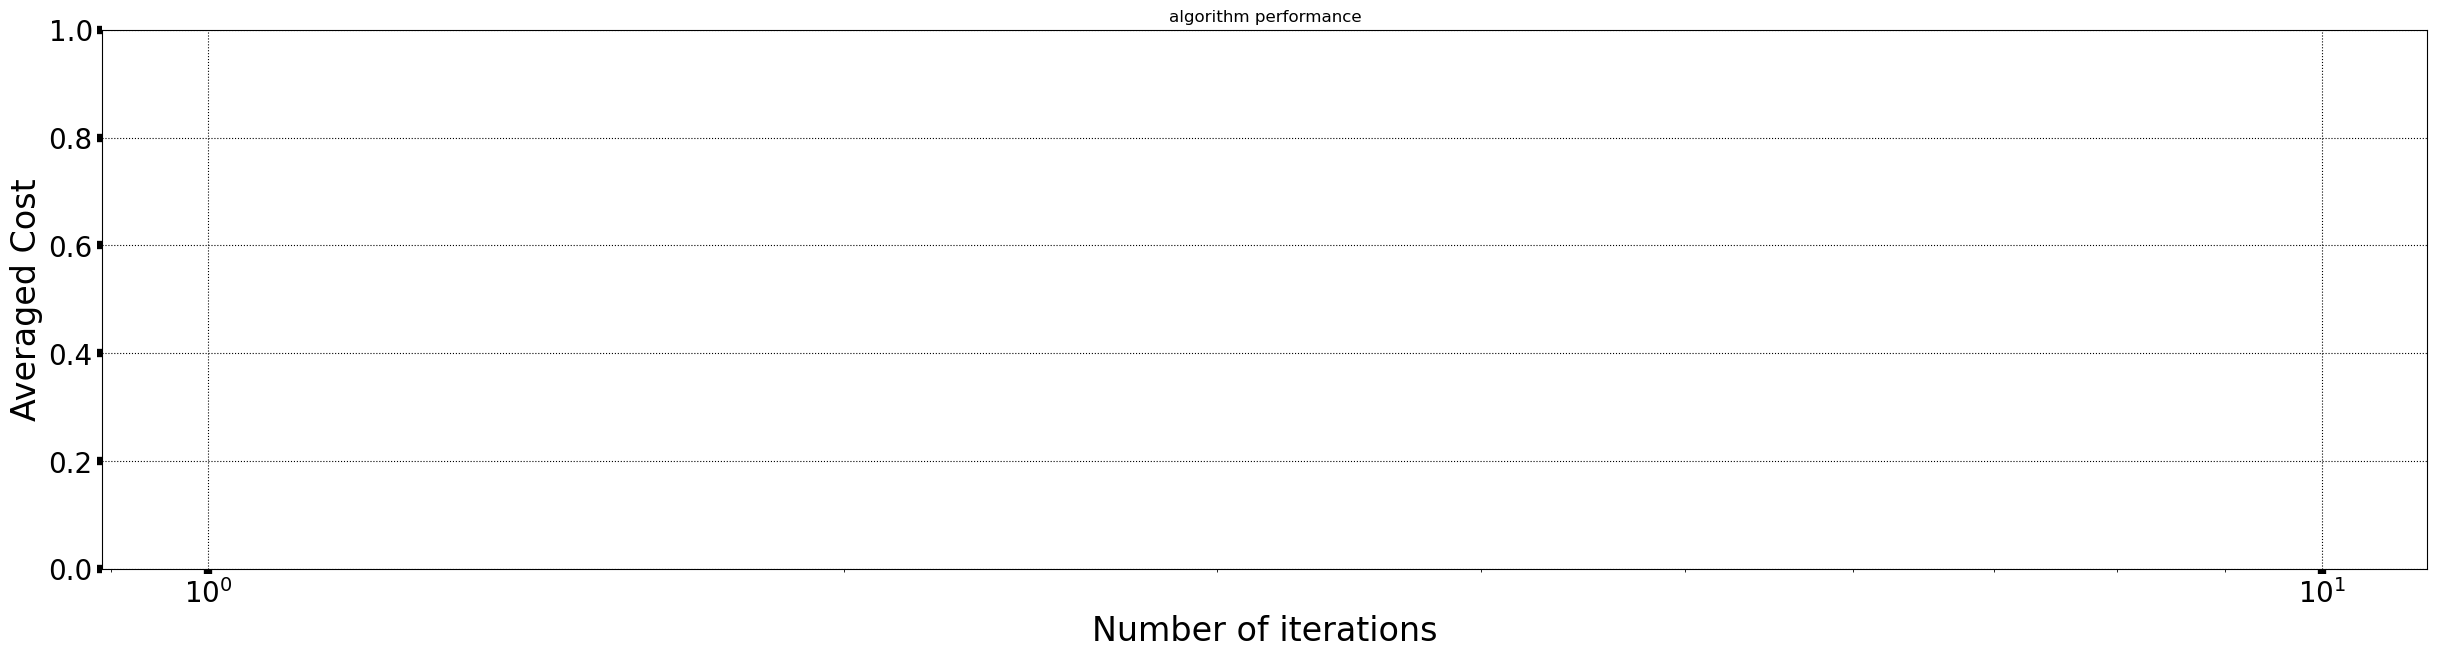

In [30]:
_, ax = plt.subplots(figsize=(30, 7))
ax.set(xscale="log", yscale="linear")
ax.set_title("algorithm performance")
sns.lineplot(x="iterations", y="cost", data=df, ax=ax)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Cost")
ax.xaxis.grid(True)
ax.set_xlabel("Number of iterations", fontsize=24)
ax.set_ylabel("Averaged Cost",fontsize=24)
ax.grid()
ax.xaxis.grid(True, color='black', linestyle='dotted')
ax.yaxis.grid(True, color='black', linestyle='dotted')
xticks = ax.xaxis.get_major_ticks()
yticks = ax.yaxis.get_major_ticks()
for tick in xticks:
    tick.label1.set_fontsize(20)
#    tick.label1.set_rotation(45)
for tick in yticks:
    tick.label1.set_fontsize(20)
ax.tick_params(width=6, colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

## Feel free to plot the rest of the results